In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import math
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import svm
from matplotlib import style
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve
style.use("ggplot")
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# FUNCTIONS
#reads in all the sample names used as keys in the dictionary
def getFileNames(file, exp):
    samples_list = []
    inFile = open(file, 'r')
    for line in inFile:
        splitLine=line.strip().split('\n')
        name=splitLine[0]
        if exp in name:
            samples_list.append(name)
#         elif exp not in name:
#             print(name)
    inFile.close()
    return samples_list
    
#normalizes for sequencing depth CPM counts per million and for enhancer length KB (kilobase)
def normalize_CPKM(exp_dict):
    for name, counts in exp_dict.items():
        count_per_enhancer = [x[0] for x in counts]
        total_counts_per_sample = sum(count_per_enhancer)
        cpkm_vals = [(tup[0] / (tup[1] * total_counts_per_sample)) * 10**9 for tup in counts]
        exp_dict[name] = cpkm_vals


def run_ds_on_exp(samples_dir, rel_path, exp):
    sampleDict = {}
    samples = getFileNames(samples_dir, exp)
    for sample in samples:
        cts_counts_wlength(rel_path, sample, sampleDict)
    
    #rename dictionary keys to specify conditions and replicates         
    rename_keys(sampleDict)

    #normalize the data using CPKM
    normDict = norm(sampleDict, exp)

    return normDict

def norm(sampleDict, exp):
    #normalize, combine replicates, log cpkm values of replicates
    normalize_CPKM(sampleDict)
    replicates_cpkm = combine_replicates_cpkm(sampleDict, exp)
    logged_replicates = log_replicates_cpkm(replicates_cpkm)
    return logged_replicates 

def log_replicates_cpkm(replicates):
    log_replicates_cpkm = {}
    for sample_name, counts in replicates.items():
        log_replicates_cpkm[sample_name] = [np.log(x+1) for x in counts]
    return log_replicates_cpkm
 
def rename(sampleDict, r1, r2, condition):
    #dictionary[new_key] = dictionary.pop(old_key)
    #https://stackoverflow.com/questions/4406501/change-the-name-of-a-key-in-dictionary
    sampleDict['En_'+condition+'_r1'] = sampleDict.pop(r1+'_end')
    sampleDict['Fb_'+condition+'_r1'] = sampleDict.pop(r1+'_fib')
    sampleDict['My_'+condition+'_r1'] = sampleDict.pop(r1+'_mye')

    sampleDict['En_'+condition+'_r2'] = sampleDict.pop(r2+'_end')
    sampleDict['Fb_'+condition+'_r2'] = sampleDict.pop(r2+'_fib')
    sampleDict['My_'+condition+'_r2'] = sampleDict.pop(r2+'_mye')

def rename_keys(sampleDict):
    rename(sampleDict, 'Sample1', 'Sample2', 'Sham')
    rename(sampleDict, 'Sample3', 'Sample4', 'TAC')
    rename(sampleDict, 'Sample5', 'Sample6', 'JQ1W')
    rename(sampleDict, 'Sample7', 'Sample8', 'JQ1')
        
def combine(sampleDict, cellType, condition):
    combined = []
    for s1,s2 in zip(sampleDict[cellType+'_'+condition+'_r1'],sampleDict[cellType+'_'+condition+'_r2']):
        combined.append(s1+s2)
    return combined

#combine replicate cpkm values        
def combine_replicates_cpkm(sampleDict, exp):
    replicateDict = {}  
    replicateDict[exp +'_Endo_Sham'] = combine(sampleDict, 'En', 'Sham')
    replicateDict[exp +'_Fb_Sham'] = combine(sampleDict, 'Fb', 'Sham')
    replicateDict[exp +'_Mye_Sham'] = combine(sampleDict, 'My', 'Sham')
    
    replicateDict[exp +'_Endo_TAC'] = combine(sampleDict, 'En', 'TAC')
    replicateDict[exp +'_Fb_TAC'] = combine(sampleDict, 'Fb', 'TAC')
    replicateDict[exp +'_Mye_TAC'] = combine(sampleDict, 'My', 'TAC')
    
    replicateDict[exp +'_Endo_JQ1W'] = combine(sampleDict, 'En', 'JQ1W')
    replicateDict[exp +'_Fb_JQ1W'] = combine(sampleDict, 'Fb', 'JQ1W')
    replicateDict[exp +'_Mye_JQ1W'] = combine(sampleDict, 'My', 'JQ1W')
    
    replicateDict[exp +'_Endo_JQ1'] = combine(sampleDict, 'En', 'JQ1')
    replicateDict[exp +'_Fb_JQ1'] = combine(sampleDict, 'Fb', 'JQ1')
    replicateDict[exp +'_Mye_JQ1'] = combine(sampleDict, 'My', 'JQ1')
    
    return replicateDict
    
   
       
#stores cell type specific (cts) counts and length of enhancer as tuples into a dictionary using samples as key
def cts_counts_wlength(rel_path, file, exp_dict):
    counts_endo = []
    counts_fib = []
    counts_mye = []
    inFile = open(rel_path + file, 'r')
    for line in inFile:
        splitLine=line.strip().split('\t')
        start_pos = int(splitLine[1])
        end_pos = int(splitLine[2])
        length = (end_pos - start_pos)+1
        val_endo = int(splitLine[3])
        val_fib = int(splitLine[4])
        val_mye = int(splitLine[5])
        counts_endo.append((val_endo,length))
        counts_fib.append((val_fib,length))
        counts_mye.append((val_mye,length))
    inFile.close()
    sample = file[:7]
#     print(len(counts_endo), len(counts_fib), len(counts_mye))
    exp_dict[sample + '_end'] = counts_endo
    exp_dict[sample + '_fib'] = counts_fib
    exp_dict[sample + '_mye'] = counts_mye

def merge(expDict, cellType, exp):
    count = 0
    mergeList = []
    for w,x,y,z in zip(expDict[exp+'_'+cellType+'_Sham'], 
                       expDict[exp+'_'+cellType+'_TAC'], 
                       expDict[exp+'_'+cellType+'_JQ1'], 
                       expDict[exp+'_'+cellType+'_JQ1W']):
        mergeList.append([w,x,y,z])
#         if w== 0.0 and x ==0.0 and y ==0.0 and z == 0.0:
#             count+=1
#     print(exp, cellType, count)
    return mergeList

def plot_cellType(cellType_rna, cellType_atac):
    corr = []
    for r, a in zip(cellType_rna, cellType_atac):
#         corr.append(np.log(stats.pearsonr(r, a)[0]+1))
        coeff = stats.pearsonr(r, a)[0]
        if np.isnan(coeff):
            corr.append(0)
        else:
            corr.append(stats.pearsonr(r, a)[0])
#     print(corr)
    return corr  

def aggregate_counts_exp(celltype_counts):
    #takes a dictionary that has enhancer : sham, TAC, JQ1, JQ1w
    counts = []
    for cpkm in celltype_counts:
        #for each enhancer in celltype
        #sum the counts across conditions
        sham_cpkm = cpkm[0]
        tac_cpkm = cpkm[1]
        jq1_cpkm = cpkm[2]
        jq1w_cpkm = cpkm[3]
        agg_count = sham_cpkm + tac_cpkm +jq1_cpkm + jq1w_cpkm
        counts.append(agg_count)
#     print(counts)
    return counts

def counts_vs_corr(cellType, cellType_rna, cellType_atac, ax, bins, labels, exp_count):
    
    corr = plot_cellType(cellType_rna, cellType_atac)
#     corrdf = pd.DataFrame(corr)
#     corrdf.to_csv('../../../data/projects/morin/corr.csv')
#     print(corr)
    cellType_dict = {}
    cellType_dict['Pearson\'s Correlation Coefficient'] = corr
    if exp_count == 'RNA Read Counts':
        cellType_dict['counts_agg'] = aggregate_counts_exp(cellType_rna)
        print("RNA counts on x axis")
    else:
        cellType_dict['counts_agg'] = aggregate_counts_exp(cellType_atac)
        print("ATAC counts on x axis")
    
    df = pd.DataFrame(cellType_dict)
#     df.to_csv('../../../data/projects/morin/df.csv')
#     print(df['counts_agg'].describe())
#     df[exp_count] = pd.qcut(df['counts_agg'], q=4, precision= 1)
    df[exp_count] = pd.cut(df['counts_agg'], bins=cut_bins, labels=cut_labels, 
                                   right=False)
    print(df)
    sns.set(style="whitegrid")
    vp = sns.violinplot(x=exp_count, y="Pearson\'s Correlation Coefficient", 
                        data=df, inner=None)
    sp = sns.swarmplot(x=exp_count, y="Pearson\'s Correlation Coefficient", 
                       data=df, color=".2",edgecolor='black')
    ax.set_title(cellType)
    ax = vp
    print(df[exp_count].value_counts())
    return vp  

def distance_to_gene_vs_corr(cellType, cellType_rna, cellType_atac, ax, dist):
    
    corr = plot_cellType(cellType_rna, cellType_atac)
#     corrdf = pd.DataFrame(corr)
#     corrdf.to_csv('../../../data/projects/morin/corr.csv')
#     print(corr)
    cellType_dict = {}
    cellType_dict['Pearson\'s Correlation Coefficient'] = corr
    cellType_dict['distances'] = dist

    df = pd.DataFrame(cellType_dict)
#     df.to_csv('../../../data/projects/morin/df.csv')
#     print(df['counts_agg'].describe())
    df['Distance to Nearest Gene'] = pd.qcut(df['distances'], q=5, precision= 1)
#     df['Distance to Nearest Gene'] = pd.cut(df['distances'], bins=cut_bins, labels=cut_labels, 
#                                    right=False)
    print(df)
    sns.set(style="whitegrid")
    vp = sns.violinplot(x='Distance to Nearest Gene', y="Pearson\'s Correlation Coefficient", 
                        data=df, inner='box')
#     sp = sns.swarmplot(x='Distance to Nearest Gene', y="Pearson\'s Correlation Coefficient", 
#                        data=df, color=".2",edgecolor='black')
    ax.set_title(cellType)
    ax = vp
    print(df['Distance to Nearest Gene'].value_counts())
    return vp

In [64]:
#----------------MAIN PROGRAM
rel_path = "../../../data/projects/morin/Counts/cellType_specific_counts/"

#a file containing the samples with their respective counts
# cellType_scpecific_counts.txt chr1|start_pos|end_pos|endo_count|fib_count|myo_count
samples_dir = "../../../data/projects/morin/cellType_specific_counts.txt"

#returns logged cpkm values of combined replicates
rnaDict= run_ds_on_exp(samples_dir, rel_path, "RNA")
# print(rnaDict)

#normalize atac data
atacDict= run_ds_on_exp(samples_dir, rel_path, "ATAC")

# print(atacDict)

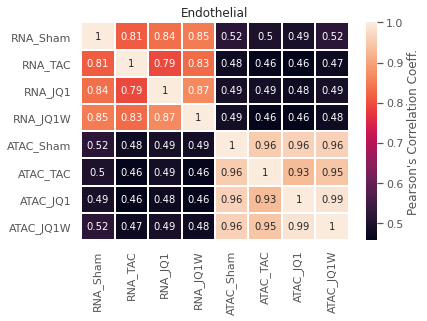

<Figure size 720x720 with 0 Axes>

In [65]:
#-----------------By cell type------------------
#merge samples for endothelial cells
mergeDict_Endo = {}
mergeDict_Endo['RNA_Sham'] = rnaDict['RNA_Endo_Sham']
mergeDict_Endo['RNA_TAC'] = rnaDict['RNA_Endo_TAC']
mergeDict_Endo['RNA_JQ1'] = rnaDict['RNA_Endo_JQ1']
mergeDict_Endo['RNA_JQ1W'] = rnaDict['RNA_Endo_JQ1W']
mergeDict_Endo['ATAC_Sham'] = atacDict['ATAC_Endo_Sham']
mergeDict_Endo['ATAC_TAC'] = atacDict['ATAC_Endo_TAC']
mergeDict_Endo['ATAC_JQ1'] = atacDict['ATAC_Endo_JQ1']
mergeDict_Endo['ATAC_JQ1W'] = atacDict['ATAC_Endo_JQ1W']



#create dataframe 
df_endo = pd.DataFrame(data=mergeDict_Endo)


#create correlation matrix using the pearson correlation coefficient
#correlation matrix for endothelial cells 
cell = "endo"

corr_matrix_endo = df_endo.corr(method = 'pearson')
plt.title('Endothelial', fontsize = 12) 
heatmap = sns.heatmap(corr_matrix_endo, annot=True, linewidths=1)
heatmap.collections[0].colorbar.set_label('Pearson\'s Correlation Coeff.', fontsize = 12)

#saves figure for plot by cell type
plt.figure(figsize=(10,10))

#get figure and save figure
img_format = '.png'
exp = "RNAvsATAC"

figure2 = "heatmap"
filename2 = figure2 + '_' + exp + '_'+ cell + img_format
fig2 = heatmap.get_figure()
fig2.savefig('../../../data/projects/morin/plots/high_res_plots/'+filename2,bbox_inches='tight',dpi=300)


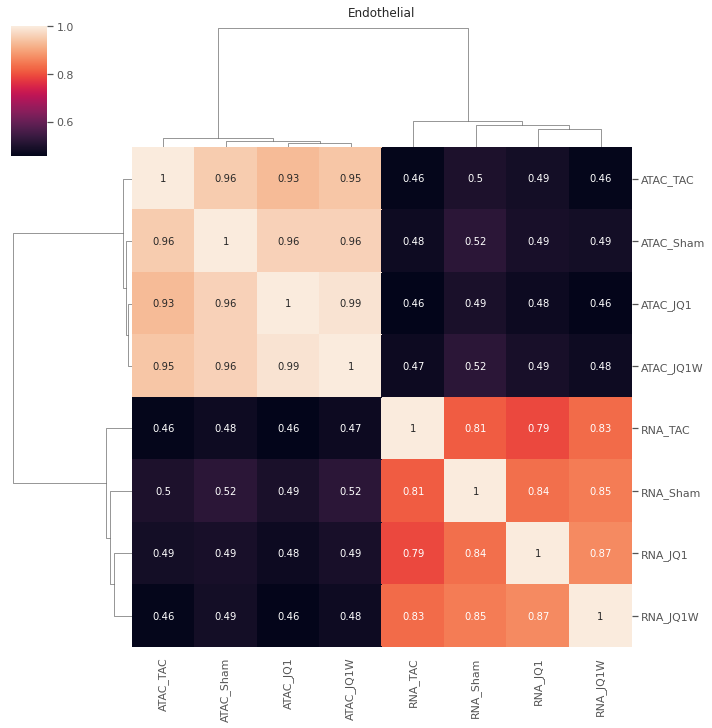

In [66]:
cluster = sns.clustermap(corr_matrix_endo, annot=True)
cluster.ax_col_dendrogram.set_title("Endothelial", fontsize=12)
figure3 = "clustermap"
filename3 = figure3 + '_' + exp + '_'+ cell + img_format
cluster.savefig('../../../data/projects/morin/plots/high_res_plots/'+filename3,bbox_inches='tight', dpi =300)


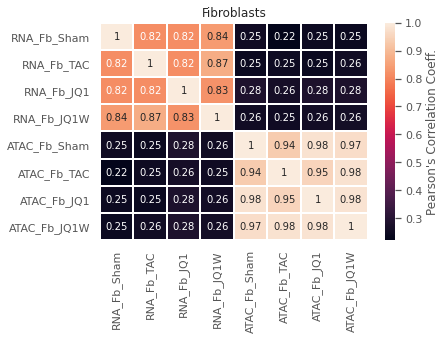

<Figure size 720x720 with 0 Axes>

In [67]:
#merge samples for fibroblast cells
mergeDict_Fb = {}
mergeDict_Fb['RNA_Fb_Sham'] = rnaDict['RNA_Fb_Sham']
mergeDict_Fb['RNA_Fb_TAC'] = rnaDict['RNA_Fb_TAC']
mergeDict_Fb['RNA_Fb_JQ1'] = rnaDict['RNA_Fb_JQ1']
mergeDict_Fb['RNA_Fb_JQ1W'] = rnaDict['RNA_Fb_JQ1W']

mergeDict_Fb['ATAC_Fb_Sham'] = atacDict['ATAC_Fb_Sham']
mergeDict_Fb['ATAC_Fb_TAC'] = atacDict['ATAC_Fb_TAC']
mergeDict_Fb['ATAC_Fb_JQ1'] = atacDict['ATAC_Fb_JQ1']
mergeDict_Fb['ATAC_Fb_JQ1W'] = atacDict['ATAC_Fb_JQ1W']


#create dataframe 
df_fb = pd.DataFrame(data=mergeDict_Fb)


# correlation matrix for fibroblast cells 
cell = "fb"
corr_matrix_fb = df_fb.corr(method = 'pearson')
plt.title('Fibroblasts', fontsize = 12) 
heatmap = sns.heatmap(corr_matrix_fb, annot=True, linewidths=1)
heatmap.collections[0].colorbar.set_label('Pearson\'s Correlation Coeff.', fontsize = 12)

#saves figure for plot by cell type
plt.figure(figsize=(10,10))


figure2 = "heatmap"
filename2 = figure2 + '_' + exp + '_'+ cell + img_format
fig2 = heatmap.get_figure()
fig2.savefig('../../../data/projects/morin/plots/high_res_plots/'+filename2,bbox_inches='tight', dpi =300)



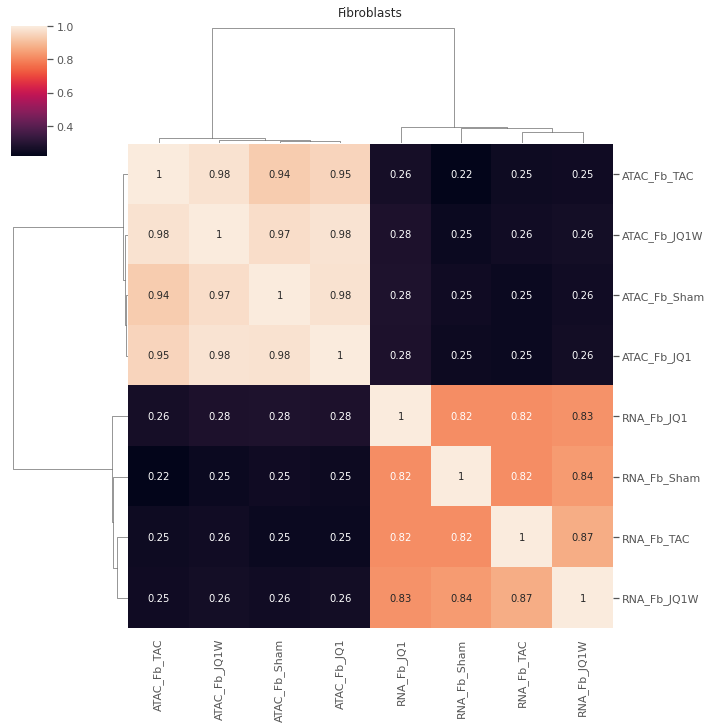

In [68]:
cluster = sns.clustermap(corr_matrix_fb, annot=True)
cluster.ax_col_dendrogram.set_title("Fibroblasts", fontsize=12)
figure3 = "clustermap"
filename3 = figure3 + '_' + exp + '_'+ cell + img_format
cluster.savefig('../../../data/projects/morin/plots/high_res_plots/'+filename3,bbox_inches='tight', dpi =300)

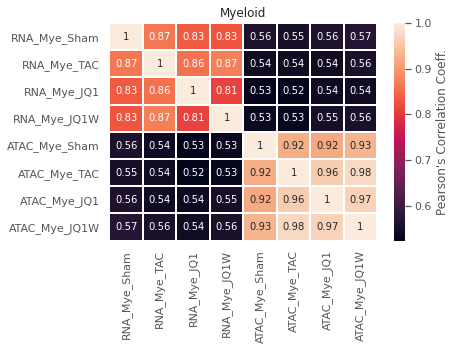

<Figure size 720x720 with 0 Axes>

In [69]:
#merge samples for myeloid cells 
mergeDict_Mye = {}
mergeDict_Mye['RNA_Mye_Sham'] = rnaDict['RNA_Mye_Sham']
mergeDict_Mye['RNA_Mye_TAC'] = rnaDict['RNA_Mye_TAC']
mergeDict_Mye['RNA_Mye_JQ1'] = rnaDict['RNA_Mye_JQ1']
mergeDict_Mye['RNA_Mye_JQ1W'] = rnaDict['RNA_Mye_JQ1W']

mergeDict_Mye['ATAC_Mye_Sham'] = atacDict['ATAC_Mye_Sham']
mergeDict_Mye['ATAC_Mye_TAC'] = atacDict['ATAC_Mye_TAC']
mergeDict_Mye['ATAC_Mye_JQ1'] = atacDict['ATAC_Mye_JQ1']
mergeDict_Mye['ATAC_Mye_JQ1W'] = atacDict['ATAC_Mye_JQ1W']


#create dataframe 
df_mye = pd.DataFrame(data=mergeDict_Mye)

# correlation matrix for myeloid cells
cell = "mye"
corr_matrix_mye = df_mye.corr(method = 'pearson')
heatmap = sns.heatmap(corr_matrix_mye, annot=True, linewidths=1)
plt.title('Myeloid', fontsize = 12) 
heatmap.collections[0].colorbar.set_label('Pearson\'s Correlation Coeff.', fontsize = 12)


#saves figure for plot by cell type
plt.figure(figsize=(10,10))


figure2 = "heatmap"
filename2 = figure2 + '_' + exp + '_'+ cell + img_format
fig2 = heatmap.get_figure()
fig2.savefig('../../../data/projects/morin/plots/high_res_plots/'+filename2,bbox_inches='tight', dpi =300)



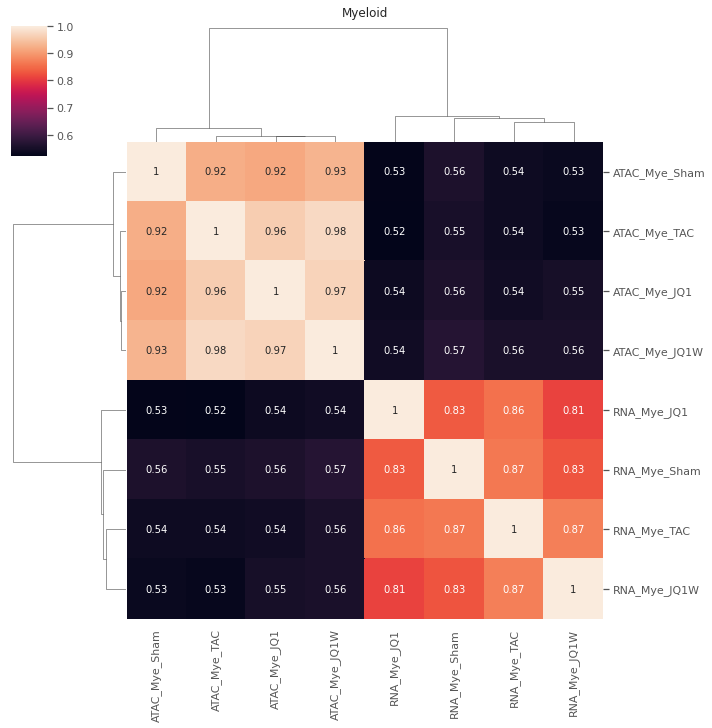

In [70]:
cluster = sns.clustermap(corr_matrix_mye, annot=True)
cluster.ax_col_dendrogram.set_title("Myeloid", fontsize=12)
figure3 = "clustermap"
filename3 = figure3 + '_' + exp + '_'+ cell + img_format
cluster.savefig('../../../data/projects/morin/plots/high_res_plots/'+filename3,bbox_inches='tight', dpi =300)

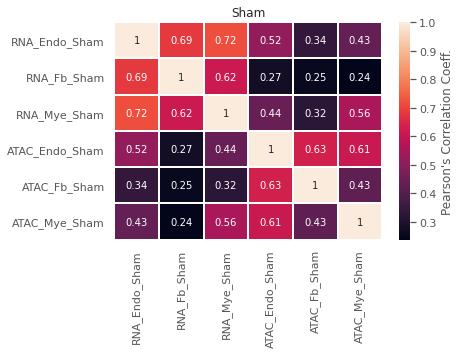

<Figure size 720x720 with 0 Axes>

In [71]:

#-----------------By condition------------------
mergeDict_Sham= {}
mergeDict_TAC = {}
mergeDict_JQ1W = {}
mergeDict_JQ1 = {}

# #merge samples for Sham
mergeDict_Sham['RNA_Endo_Sham'] = rnaDict['RNA_Endo_Sham']
mergeDict_Sham['RNA_Fb_Sham'] = rnaDict['RNA_Fb_Sham']
mergeDict_Sham['RNA_Mye_Sham'] = rnaDict['RNA_Mye_Sham']
mergeDict_Sham['ATAC_Endo_Sham'] = atacDict['ATAC_Endo_Sham']
mergeDict_Sham['ATAC_Fb_Sham'] = atacDict['ATAC_Fb_Sham']
mergeDict_Sham['ATAC_Mye_Sham'] = atacDict['ATAC_Mye_Sham']

# #merge samples for TAC
mergeDict_TAC['RNA_Endo_TAC'] = rnaDict['RNA_Endo_TAC']
mergeDict_TAC['RNA_Fb_TAC'] = rnaDict['RNA_Fb_TAC']
mergeDict_TAC['RNA_Mye_TAC'] = rnaDict['RNA_Mye_TAC']
mergeDict_TAC['ATAC_Endo_TAC'] = atacDict['ATAC_Endo_TAC']
mergeDict_TAC['ATAC_Fb_TAC'] = atacDict['ATAC_Fb_TAC']
mergeDict_TAC['ATAC_Mye_TAC'] = atacDict['ATAC_Mye_TAC']

# #merge samples for JQ1
mergeDict_JQ1['RNA_Endo_JQ1'] = rnaDict['RNA_Endo_JQ1']
mergeDict_JQ1['RNA_Fb_JQ1'] = rnaDict['RNA_Fb_JQ1']
mergeDict_JQ1['RNA_Mye_JQ1'] = rnaDict['RNA_Mye_JQ1']
mergeDict_JQ1['ATAC_Endo_JQ1'] = atacDict['ATAC_Endo_JQ1']
mergeDict_JQ1['ATAC_Fb_JQ1'] = atacDict['ATAC_Fb_JQ1']
mergeDict_JQ1['ATAC_Mye_JQ1'] = atacDict['ATAC_Mye_JQ1']

# #merge samples for JQ1W
mergeDict_JQ1W['RNA_Endo_JQ1W'] = rnaDict['RNA_Endo_JQ1W']
mergeDict_JQ1W['RNA_Fb_JQ1W'] = rnaDict['RNA_Fb_JQ1W']
mergeDict_JQ1W['RNA_Mye_JQ1W'] = rnaDict['RNA_Mye_JQ1W']
mergeDict_JQ1W['ATAC_Endo_JQ1W'] = atacDict['ATAC_Endo_JQ1W']
mergeDict_JQ1W['ATAC_Fb_JQ1W'] = atacDict['ATAC_Fb_JQ1W']
mergeDict_JQ1W['ATAC_Mye_JQ1W'] = atacDict['ATAC_Mye_JQ1W']





# #create dataframe 
df_sham = pd.DataFrame(data=mergeDict_Sham)

df_tac = pd.DataFrame(data=mergeDict_TAC)

df_jq1w = pd.DataFrame(data=mergeDict_JQ1W)

df_jq1 = pd.DataFrame(data=mergeDict_JQ1)


condition = "Sham"
corr_matrix_sham = df_sham.corr(method = 'pearson')
heatmap = sns.heatmap(corr_matrix_sham, annot=True, linewidths=1)

plt.title('Sham', fontsize = 12) 
heatmap.collections[0].colorbar.set_label('Pearson\'s Correlation Coeff.', fontsize = 12)


#saves figure for plot by condition
plt.figure(figsize=(10,10))

figure2 = "heatmap"
filename2 = figure2 + '_' + exp + '_'+ condition + img_format
fig2 = heatmap.get_figure()
fig2.savefig('../../../data/projects/morin/plots/high_res_plots/'+filename2,bbox_inches='tight', dpi =300)

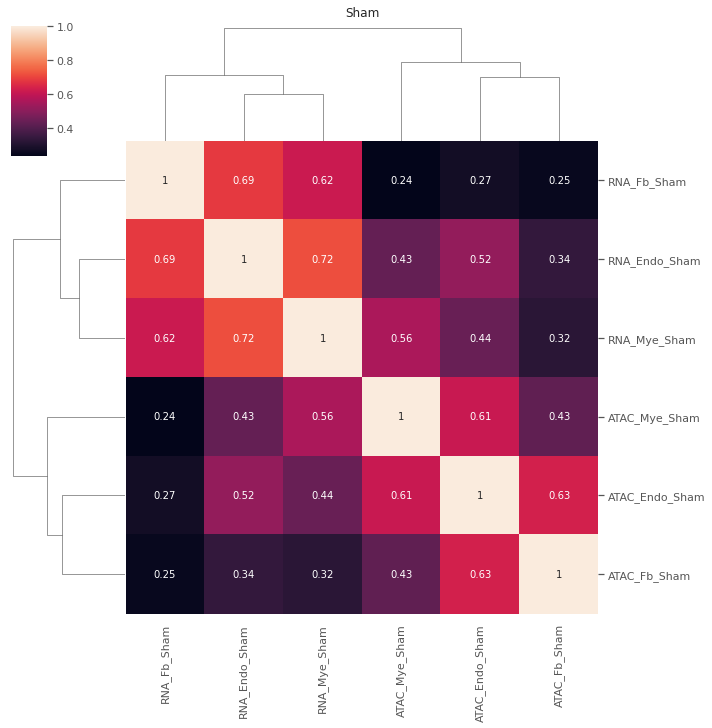

<Figure size 720x720 with 0 Axes>

In [72]:
cluster = sns.clustermap(corr_matrix_sham, annot=True)
cluster.ax_col_dendrogram.set_title("Sham", fontsize=12)
#saves figure for plot by condition
plt.figure(figsize=(10,10))

figure3 = "clustermap"
filename3 = figure3 + '_' + exp + '_'+ condition + img_format
cluster.savefig('../../../data/projects/morin/plots/high_res_plots/'+filename3,bbox_inches='tight', dpi =300)

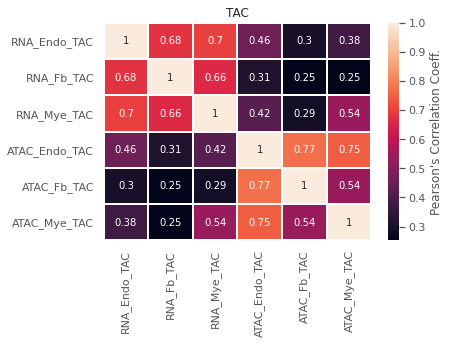

<Figure size 720x720 with 0 Axes>

In [73]:
condition = "TAC"
corr_matrix_tac = df_tac.corr(method = 'pearson')
heatmap = sns.heatmap(corr_matrix_tac, annot=True, linewidths=1)
plt.title('TAC', fontsize = 12) 
#saves figure for plot by condition
plt.figure(figsize=(10,10))

heatmap.collections[0].colorbar.set_label('Pearson\'s Correlation Coeff.', fontsize = 12)

figure2 = "heatmap"
filename2 = figure2 + '_' + exp + '_'+ condition + img_format
fig2 = heatmap.get_figure()
fig2.savefig('../../../data/projects/morin/plots/high_res_plots/'+filename2,bbox_inches='tight', dpi =300)

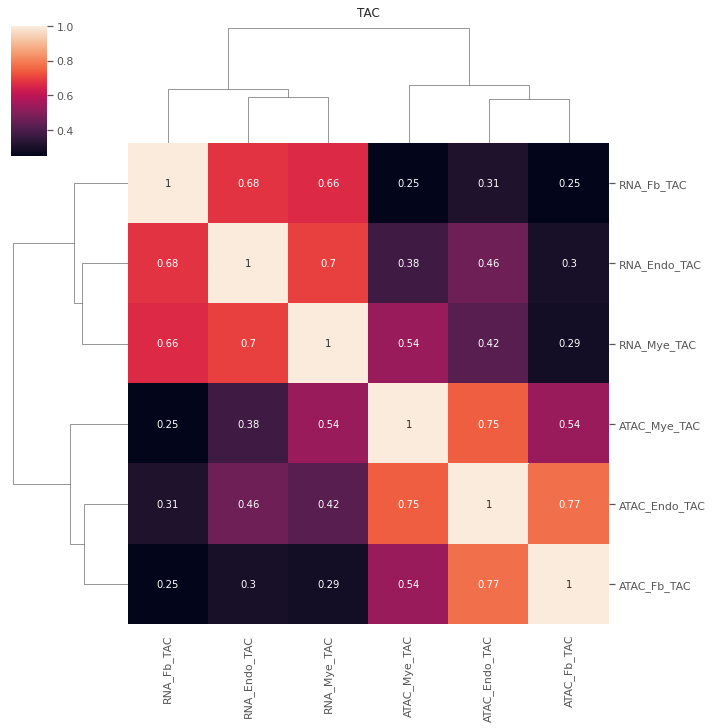

<Figure size 720x720 with 0 Axes>

In [74]:
cluster = sns.clustermap(corr_matrix_tac, annot=True)
cluster.ax_col_dendrogram.set_title("TAC", fontsize=12)
#saves figure for plot by condition
plt.figure(figsize=(10,10))

figure3 = "clustermap"
filename3 = figure3 + '_' + exp + '_'+ condition + img_format
cluster.savefig('../../../data/projects/morin/plots/high_res_plots/'+filename3,bbox_inches='tight', dpi =300)

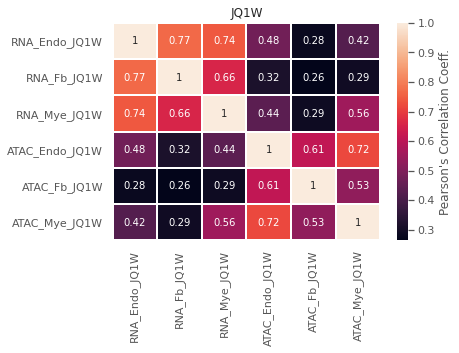

<Figure size 720x720 with 0 Axes>

In [75]:
condition = "JQ1W"
corr_matrix_jq1w = df_jq1w.corr(method = 'pearson')
heatmap = sns.heatmap(corr_matrix_jq1w, annot=True, linewidths=1)
plt.title('JQ1W', fontsize = 12) 
#saves figure for plot by condition
plt.figure(figsize=(10,10))


heatmap.collections[0].colorbar.set_label('Pearson\'s Correlation Coeff.', fontsize = 12)

figure2 = "heatmap"
filename2 = figure2 + '_' + exp + '_'+ condition + img_format
fig2 = heatmap.get_figure()
fig2.savefig('../../../data/projects/morin/plots/high_res_plots/'+filename2,bbox_inches='tight', dpi =300)

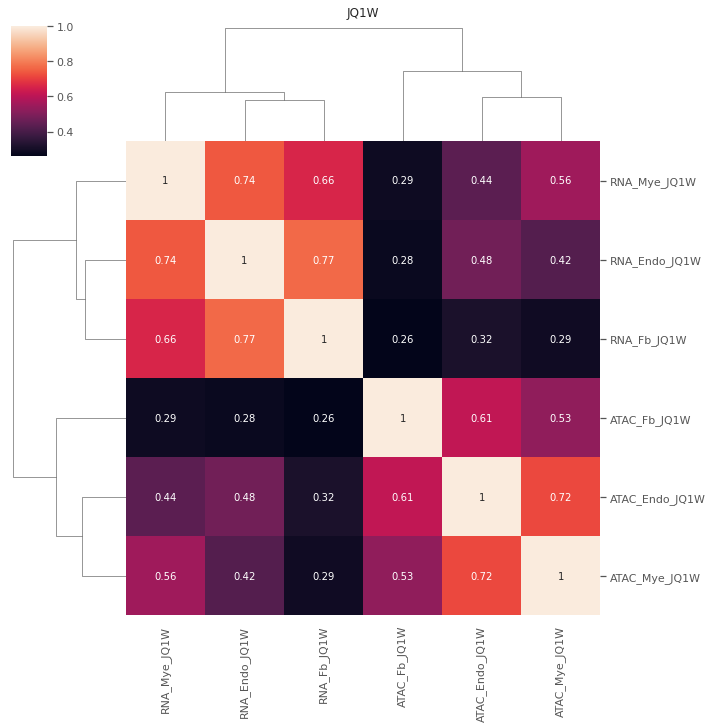

<Figure size 720x720 with 0 Axes>

In [76]:
cluster = sns.clustermap(corr_matrix_jq1w, annot=True)
cluster.ax_col_dendrogram.set_title("JQ1W", fontsize=12)
#saves figure for plot by condition
plt.figure(figsize=(10,10))

figure3 = "clustermap"
filename3 = figure3 + '_' + exp + '_'+ condition + img_format
cluster.savefig('../../../data/projects/morin/plots/high_res_plots/'+filename3,bbox_inches='tight', dpi =300)

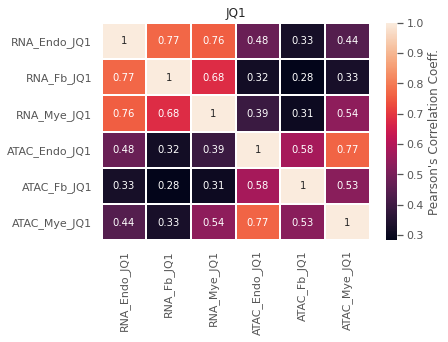

<Figure size 720x720 with 0 Axes>

In [77]:
condition = "JQ1"
corr_matrix_jq1  = df_jq1 .corr(method = 'pearson')
heatmap = sns.heatmap(corr_matrix_jq1 , annot=True, linewidths=1)
plt.title('JQ1', fontsize = 12) 
#saves figure for plot by condition
plt.figure(figsize=(10,10))

heatmap.collections[0].colorbar.set_label('Pearson\'s Correlation Coeff.', fontsize = 12)


figure2 = "heatmap"
filename2 = figure2 + '_' + exp + '_'+ condition + img_format
fig2 = heatmap.get_figure()
fig2.savefig('../../../data/projects/morin/plots/high_res_plots/'+filename2,bbox_inches='tight', dpi =300)

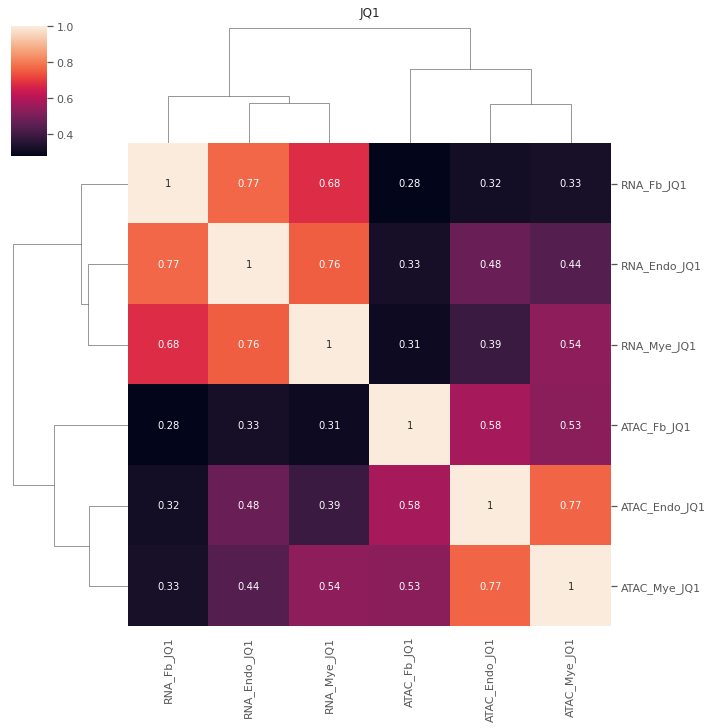

<Figure size 720x720 with 0 Axes>

In [78]:
cluster = sns.clustermap(corr_matrix_jq1 , annot=True)
cluster.ax_col_dendrogram.set_title("JQ1", fontsize=12)
#saves figure for plot by condition
plt.figure(figsize=(10,10))

figure3 = "clustermap"
filename3 = figure3 + '_' + exp + '_'+ condition + img_format
cluster.savefig('../../../data/projects/morin/plots/high_res_plots/'+filename3,bbox_inches='tight', dpi =300)

In [79]:
#------------------Closest Distance to Gene vs Pearson's Correlation
#create a dictionary that follows the order of enhancers.bed
#have to do this step because bedtools sort puts them in a different order
#merge conditions within celltypes for ATAC
endo_atac = merge(atacDict, 'Endo', 'ATAC')
fib_atac = merge(atacDict, 'Fb', 'ATAC')
mye_atac = merge(atacDict, 'Mye', 'ATAC')

#merge conditions within celltypes for RNA
endo_rna = merge(rnaDict, 'Endo', 'RNA')
fib_rna = merge(rnaDict, 'Fb', 'RNA')
mye_rna = merge(rnaDict, 'Mye', 'RNA')

wdir= '../../../data/projects/morin/'
inFile = open(wdir+'enhancers.bed', 'r')
closest_gene = {}
for line in inFile:
    splitLine = line.strip().split('\t')
#     print(splitLine)
    chrom = splitLine[0]
    start =  splitLine[1]
    end = splitLine[2]
    key = chrom + ':' + start + ':'+ end
    start_list = 0
    closest_gene[key] = start_list     
inFile.close()

#add the distances
inFile = open('../../../data/projects/morin/closest/closest_genes_Did_wrtA_tFirst.bed', 'r')
# inFile = open('../../../data/projects/morin/closest/closest_genes_td.bed', 'r')

for line in inFile:
    splitLine=line.strip().split('\t')
#     print(splitLine)
    chrom = splitLine[0]
    start =  splitLine[1]
    end = splitLine[2]
    
    key = chrom + ':' + start + ':'+ end
#     print(key)
    #since we are using upstream the values will be negative so convert to abs val
    dist_to_gene = np.absolute(int(splitLine[9]))
#     print(dist_to_gene)
    closest_gene[key] = dist_to_gene
inFile.close()

dist = []
for key in closest_gene.keys():
    dist.append(closest_gene[key])
#     print(key, closest_gene[key])

/pollard/home/smorin/miniconda3/envs/r-environment/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


     Pearson's Correlation Coefficient  distances Distance to Nearest Gene
0                            -0.912412      16821       (16264.6, 45931.4]
1                            -0.959987          0           (-0.1, 3846.4]
2                             0.073904       1839           (-0.1, 3846.4]
3                             0.892643      10649        (3846.4, 16264.6]
4                             0.126175      46480      (45931.4, 111800.0]
..                                 ...        ...                      ...
465                           0.000000          0           (-0.1, 3846.4]
466                          -0.448593          0           (-0.1, 3846.4]
467                          -0.626096          0           (-0.1, 3846.4]
468                          -0.610557       6337        (3846.4, 16264.6]
469                          -0.252455     212829    (111800.0, 1585388.0]

[470 rows x 3 columns]
(111800.0, 1585388.0]    94
(45931.4, 111800.0]      94
(16264.6, 45931.4]  

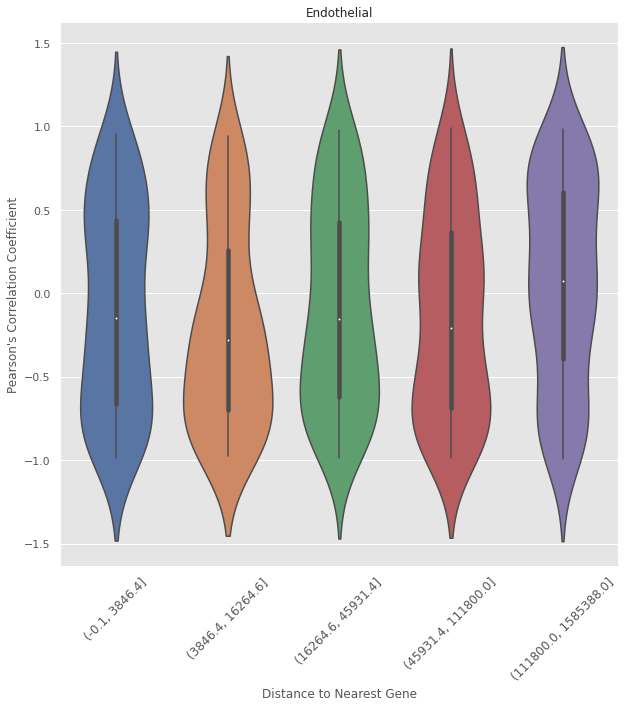

In [80]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,10), sharex=True, sharey=True)
vp = distance_to_gene_vs_corr('Endothelial', endo_rna, endo_atac, axs, dist)
plt.xticks(rotation=45, fontsize=12)
plt.savefig('../../../data/projects/morin/plots/high_res_plots/endo_vp_id',bbox_inches='tight', dpi =300)

/pollard/home/smorin/miniconda3/envs/r-environment/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


     Pearson's Correlation Coefficient  distances Distance to Nearest Gene
0                            -0.315642      16821       (16264.6, 45931.4]
1                             0.412090          0           (-0.1, 3846.4]
2                            -0.276700       1839           (-0.1, 3846.4]
3                             0.863951      10649        (3846.4, 16264.6]
4                            -0.157353      46480      (45931.4, 111800.0]
..                                 ...        ...                      ...
465                          -0.300028          0           (-0.1, 3846.4]
466                           0.342483          0           (-0.1, 3846.4]
467                           0.023048          0           (-0.1, 3846.4]
468                           0.381584       6337        (3846.4, 16264.6]
469                           0.929820     212829    (111800.0, 1585388.0]

[470 rows x 3 columns]
(111800.0, 1585388.0]    94
(45931.4, 111800.0]      94
(16264.6, 45931.4]  

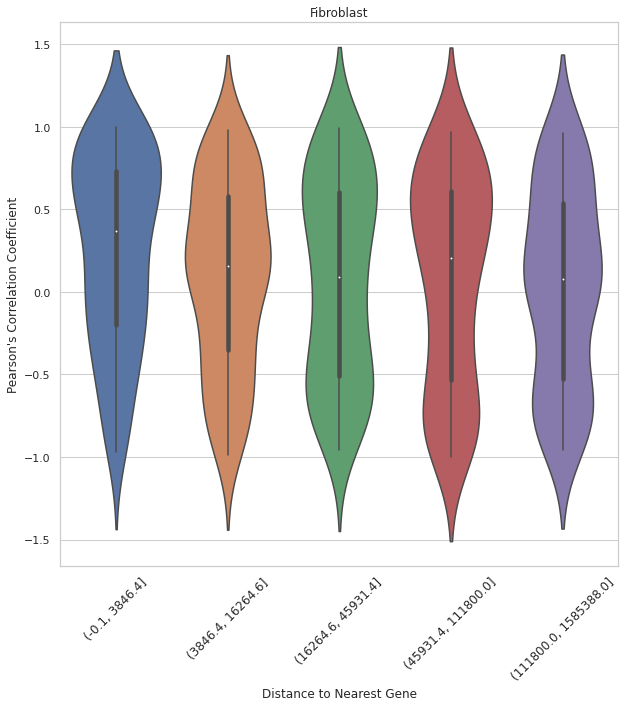

In [81]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,10), sharex=True, sharey=True)
vp = distance_to_gene_vs_corr('Fibroblast', fib_rna, fib_atac, axs, dist)
plt.xticks(rotation=45, fontsize=12)
plt.savefig('../../../data/projects/morin/plots/high_res_plots/fb_vp_id',bbox_inches='tight', dpi =300)

/pollard/home/smorin/miniconda3/envs/r-environment/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


     Pearson's Correlation Coefficient  distances Distance to Nearest Gene
0                            -0.690373      16821       (16264.6, 45931.4]
1                            -0.083281          0           (-0.1, 3846.4]
2                             0.459542       1839           (-0.1, 3846.4]
3                            -0.540502      10649        (3846.4, 16264.6]
4                             0.672986      46480      (45931.4, 111800.0]
..                                 ...        ...                      ...
465                          -0.451477          0           (-0.1, 3846.4]
466                           0.302845          0           (-0.1, 3846.4]
467                          -0.204112          0           (-0.1, 3846.4]
468                          -0.516266       6337        (3846.4, 16264.6]
469                           0.000000     212829    (111800.0, 1585388.0]

[470 rows x 3 columns]
(111800.0, 1585388.0]    94
(45931.4, 111800.0]      94
(16264.6, 45931.4]  

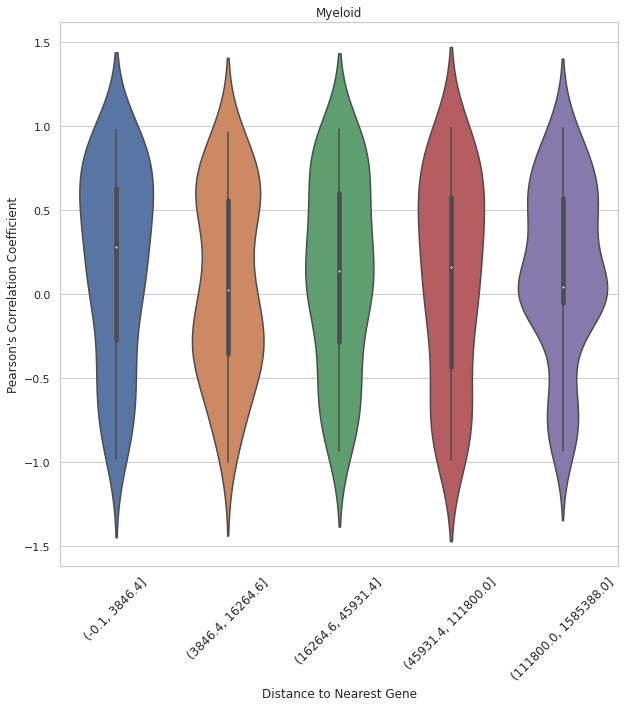

In [82]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,10), sharex=True, sharey=True)
vp = distance_to_gene_vs_corr('Myeloid', mye_rna, mye_atac, axs, dist)
plt.xticks(rotation=45, fontsize=12)
plt.savefig('../../../data/projects/morin/plots/high_res_plots/mye_vp_id',bbox_inches='tight', dpi =300)

In [83]:
#For our labels, sometimes referred to as "targets," we're going to use 0 or 1
#from ATAC data
#generate an array of dynamic vs non dynamic
def create_binary_array(cellType_atac):
    binary_array = []
    for condition in cellType_atac:
        #order: sham, TAC, JQ1, JQ1W
        #       0      1    2    3
        unstressed = condition[0] + condition[2]
        stressed = condition[1] + condition[3]
#         unstressed = condition[0]
#         stressed = condition[1]
        if stressed > unstressed:
            binary_array.append(1) #dynamic enhancer
        else:
            binary_array.append(0) #non-dynamic enhancer
    return binary_array 

#merge conditions within celltypes for RNA
endo_rna = merge(rnaDict, 'Endo', 'RNA')
fib_rna = merge(rnaDict, 'Fb', 'RNA')
mye_rna = merge(rnaDict, 'Mye', 'RNA')


#merge conditions within celltypes for ATAC
endo_atac = merge(atacDict, 'Endo', 'ATAC')
fib_atac = merge(atacDict, 'Fb', 'ATAC')
mye_atac = merge(atacDict, 'Mye', 'ATAC')

In [84]:
wdir= '../../../data/projects/morin/'
inFile = open(wdir+'proseq/enhancers_log2foldchange.csv', 'r')
l2fchange = []
for line in inFile:
    splitLine = line.strip().split('\t')
    val = float(splitLine[3])
    l2fchange.append(val)

#change this depending on cell type we are analyzing
#the feature list being stored in a capital X variable
# sham ,tac, jq1, jq1w], #unstressed , stressed, unstressed, stressed
X= np.array(mye_rna) #accessing the features for celltype 
binary_array = create_binary_array(mye_atac) #ATAC data is used for labels only
y = binary_array
cell= 'Mye' #for accessing conditions in RNA dictionary
cellType = 'Myeloid' #for plot title


#make a data frame with : labels (dynamic vs non dynamic), sham, tac, jq1, jq1w)
table = {}
table['labels'] = binary_array
table['Sham'] = rnaDict['RNA_'+cell+'_Sham']
table['TAC'] = rnaDict['RNA_'+cell+'_TAC']
table['JQ1'] = rnaDict['RNA_'+cell+'_JQ1']
table['JQ1W'] = rnaDict['RNA_'+cell+'_JQ1W']
table['proseq_l2fc'] = l2fchange 

df = pd.DataFrame(data=table)
print(df)

X_train, X_test, y_train, y_test = train_test_split(df.drop('labels', axis=1), df.labels, test_size=0.3)

test_0 = ['Sham', 'TAC', 'JQ1', 'JQ1W', 'proseq_l2fc']
test_1 = ['Sham', 'JQ1W','proseq_l2fc']
test_2 = ['TAC', 'JQ1','proseq_l2fc']
test_3 = ['Sham', 'TAC','proseq_l2fc']
test_4 = ['JQ1', 'JQ1W','proseq_l2fc']
test_5 = ['Sham', 'TAC', 'JQ1','proseq_l2fc']
test_6 = ['Sham', 'TAC', 'JQ1W','proseq_l2fc']
test_7 = ['Sham', 'JQ1', 'JQ1W','proseq_l2fc']
test_8 = ['TAC', 'JQ1', 'JQ1W','proseq_l2fc']



features = [test_0, test_1, test_2, test_3, test_4, test_5, test_6, 
            test_7, test_8]
names = ['0', '1', '2', '3', '4', '5', '6', '7', '8']




#get the fractions of 1s and 0s - our preditiction has to be greater than this fraction 
#(means we are better than random), baseline is dynamic/total
count=0
for x in binary_array:
    if x == 1:
        count+=1
print("dynamic enhancers over total enhancers:", count/len(binary_array))

     labels      Sham       TAC       JQ1      JQ1W  proseq_l2fc
0         0  3.854234  3.698294  4.258182  4.737382     1.536834
1         1  2.343248  1.619470  2.490081  0.000000     0.986674
2         1  0.000000  0.648613  1.351769  0.000000     1.025116
3         1  2.448645  2.537463  2.712933  1.698852     0.122344
4         1  0.000000  0.000000  2.682026  0.000000    -0.167291
..      ...       ...       ...       ...       ...          ...
465       1  1.753664  1.871757  0.000000  0.000000     0.561887
466       1  4.619321  3.979481  4.948248  4.375600    -1.419198
467       1  1.068480  2.120010  0.000000  2.021085    -0.222549
468       1  2.526087  1.974035  3.079394  1.346421     0.716538
469       1  0.000000  0.000000  0.000000  0.000000     0.459669

[470 rows x 6 columns]
dynamic enhancers over total enhancers: 0.6425531914893617


[0.86897372 0.0551429 ]
(470, 2)


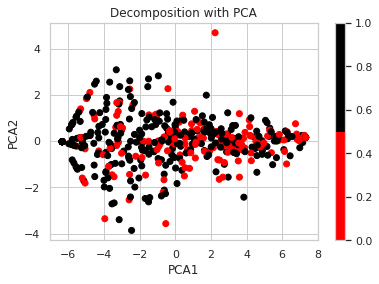

In [85]:
#run PCA to see if data is separable
import matplotlib.colors as mcolors

# print(len(np.clip(X, np.percentile(X, 5, axis=0), np.percentile(X, 95, axis=0))))
#reduces 5 features into 2D
pca = PCA(n_components = 2)
X2D = pca.fit_transform(np.clip(X, np.percentile(X, 5, axis=0), np.percentile(X, 95, axis=0)))
print(pca.explained_variance_ratio_)
print(X2D.shape)

cmap = mcolors.ListedColormap(['red', '#000000'])
plt.scatter(X2D[:, 0], X2D[:, 1], c = y, cmap = cmap)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Decomposition with PCA')
plt.colorbar()
plt.savefig('../../../data/projects/morin/plots/high_res_plots/PCA_2d',bbox_inches='tight', dpi =300)


Text(0.5, 1.0, 'Decomposition with TSNE')

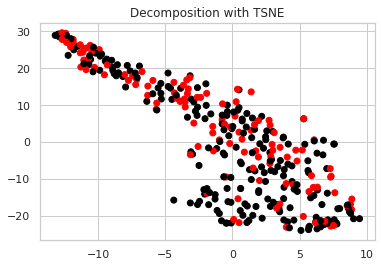

In [86]:
TSNE_model = TSNE(n_components = 2)
TSNE_data = TSNE_model.fit_transform(X_train)
TSNE_data.shape
dic = {}

plt.scatter(TSNE_data[:, 0], TSNE_data[:, 1], c = y_train, cmap = cmap)
plt.title('Decomposition with TSNE')
# plt.colorbar()

[0.883236   0.04915816 0.04048896]
           c1        c2        c3
0    1.803224 -0.394083  0.378942
1   -3.252441  1.713856 -0.863330
2   -5.469836  0.838150  0.566702
3   -1.780591  0.610157 -0.229453
4   -5.109310  1.867678  1.125565
..        ...       ...       ...
465 -4.691446 -0.143129 -1.442202
466  2.490090  0.371449 -0.080326
467 -3.891310 -1.606493 -0.149304
468 -2.009310  1.186458 -0.273717
469 -6.478493 -0.052251 -0.030354

[470 rows x 3 columns]


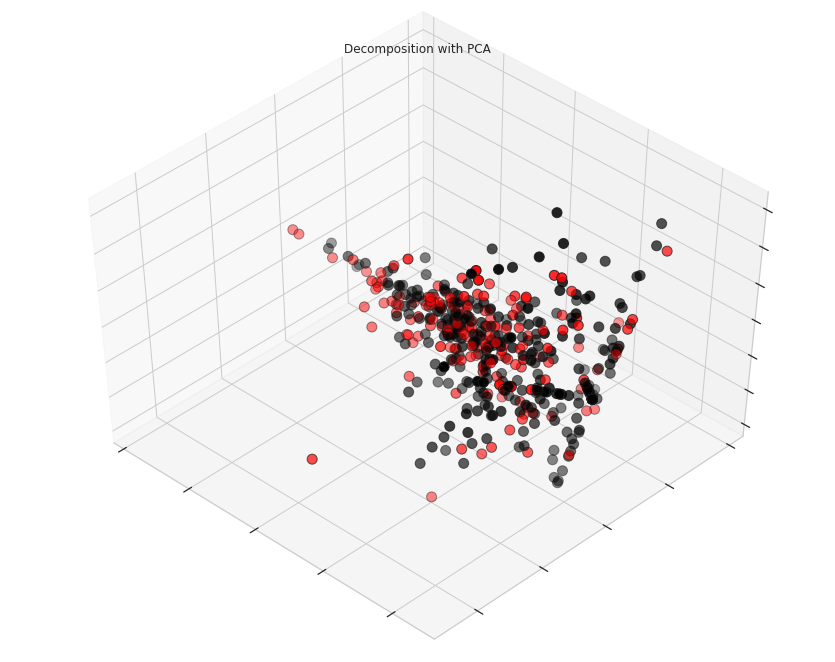

In [87]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
#https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_iris.html
np.random.seed(5)

centers = [[1, 1], [-1, -1], [1, -1]]


fig = plt.figure(1, figsize=(12, 9))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)
print(pca.explained_variance_ratio_)
# Reorder the labels to have colors matching the cluster results
# y = np.choose(y, [1, 2, 0]).astype(np.float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=cmap,
           edgecolor='k', s=100)
d = {}
d['c1'] = X[:, 0]
d['c2'] = X[:, 1]
d['c3'] = X[:, 2]
df1 = pd.DataFrame(data = d)
print(df1)
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.title('Decomposition with PCA')
plt.savefig('../../../data/projects/morin/plots/high_res_plots/PCA_3d',bbox_inches='tight', dpi =300)
plt.show()


In [88]:
#https://nbviewer.jupyter.org/github/dametreusv/world_development_indicators/blob/master/WDA_modeling.ipynb#Functions
def select_model(features, model):
    '''This function trains and predicts a multiclass classification model and displays its score'''
    
    # Fit model
    clf = model.fit(X_train[features], y_train)
    
    # Make predictions
    y_predict = clf.predict(X_test[features])
    
    # Score model
    print('Accuracy: {}'.format(accuracy_score(y_test, y_predict)))
    print(classification_report(y_test, y_predict))
    
    # Create dataframe of scored model
    global dataframe
    dataframe = pd.DataFrame(classification_report(y_test, y_predict, output_dict=True)).transpose()
    
    # Plot non-normalized confusion matrix
    plot_confusion_matrix(y_test, y_predict, classes=df.labels,
                          title='Confusion matrix, without normalization')
    
    # Plot normalized confusion matrix
    plot_confusion_matrix(y_test, y_predict, classes=df.labels, normalize=True,
                          title='Normalized confusion matrix')
    
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                         subplot=0):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = df.labels.unique()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # And label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [89]:
# Create pipeline
pipeline = make_pipeline(SVC(random_state=10))

# Select hyperparameters
hyperparameters = {'svc__C': [0.001, 0.01, 0.1, 1, 10, 100],
                  'svc__kernel': ['rbf', 'linear'],
                  'svc__gamma': [0.001, 0.01, 0.1, 1]}

# For loop to select best set of features, hyperparameters
best_score = 0
best_feature = str()
best_param = str()
# Loop
for feature, name in zip(features, names): # Go into feature
    clf = GridSearchCV(pipeline, hyperparameters, cv=5) # Check hyperparameters
    clf.fit(X_train[feature], y_train)
    if clf.best_score_ > best_score: # If better than others, save
        best_score = clf.best_score_
        best_feature = name
        best_param = clf.best_params_
        
print('best feature:', best_feature)
print('best parameters: ', best_param)
print('best score: ', best_score)

best feature: 6
best parameters:  {'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
best score:  0.6928671328671329


Accuracy: 0.6595744680851063
              precision    recall  f1-score   support

           0       0.56      0.18      0.27        50
           1       0.67      0.92      0.78        91

    accuracy                           0.66       141
   macro avg       0.62      0.55      0.53       141
weighted avg       0.63      0.66      0.60       141



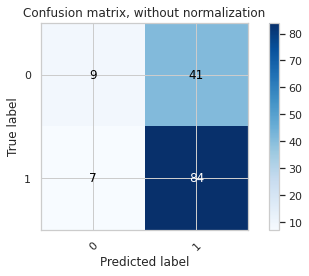

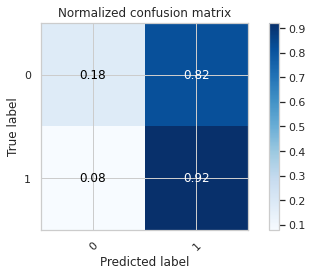

In [40]:
# Test model using the parameters from gridsearchCV
select_model(test_1, SVC(random_state=10, C=10, kernel='rbf', gamma=0.1))
# Rename dataframe
svc = dataframe

In [22]:

# Create pipeline
pipeline = make_pipeline(KNeighborsClassifier())

# Select hyperparameters
hyperparameters = {'kneighborsclassifier__n_neighbors': np.arange(1,10)}

# For loop to select best set of features, hyperparameters
best_score = 0
best_feature = str()
best_param = str()
# Loop
for feature, name in zip(features, names): # Go into feature
    clf = GridSearchCV(pipeline, hyperparameters, cv=5) # Check hyperparameters
    clf.fit(X_train[feature], y_train)
    if clf.best_score_ > best_score: # If better than others, save
        best_score = clf.best_score_
        best_feature = name
        best_param = clf.best_params_
        
print('best feature:', best_feature)
print('best parameters: ', best_param)
print('best score: ', best_score)

best feature: 7
best parameters:  {'kneighborsclassifier__n_neighbors': 9}
best score:  0.6748717948717949


Accuracy: 0.6099290780141844
              precision    recall  f1-score   support

           0       0.42      0.26      0.32        50
           1       0.66      0.80      0.73        91

    accuracy                           0.61       141
   macro avg       0.54      0.53      0.52       141
weighted avg       0.58      0.61      0.58       141



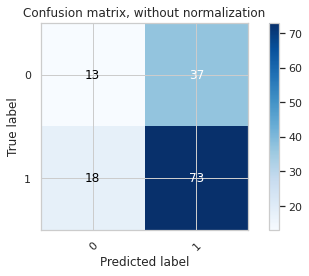

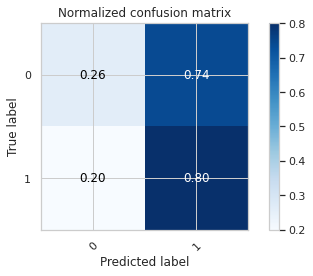

In [44]:
# Test model using the parameters from gridsearchCV
select_model(test_7, KNeighborsClassifier(n_neighbors =9))
# Rename dataframe
svc = dataframe

In [25]:
# Create pipeline
pipeline = make_pipeline(RandomForestClassifier(random_state=10))

# Select hyperparameters
hyperparameters = {'randomforestclassifier__max_features': ['sqrt', 'log2', None],
                  'randomforestclassifier__max_depth': [None, 5, 3, 1],
                  'randomforestclassifier__n_estimators': [10, 25, 50, 75, 100]}

#https://nbviewer.jupyter.org/github/dametreusv/world_development_indicators/blob/master/WDA_modeling.ipynb#rf
# For loop to select best set of features, hyperparameters
best_score = 0
best_feature = str()
best_param = str()
# Loop
for feature, name in zip(features, names): # Go into feature
    clf = GridSearchCV(pipeline, hyperparameters, cv=5) # Check hyperparameters
    clf.fit(X_train[feature], y_train)
    if clf.best_score_ > best_score: # If better than others, save
        best_score = clf.best_score_
        best_feature = name
        best_param = clf.best_params_
        
print('best feature:', best_feature)
print('best parameters: ', best_param)
print('best score: ', best_score)

best feature: 4
best parameters:  {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
best score:  0.6567832167832168


Accuracy: 0.5957446808510638
              precision    recall  f1-score   support

           0       0.33      0.14      0.20        50
           1       0.64      0.85      0.73        91

    accuracy                           0.60       141
   macro avg       0.49      0.49      0.46       141
weighted avg       0.53      0.60      0.54       141



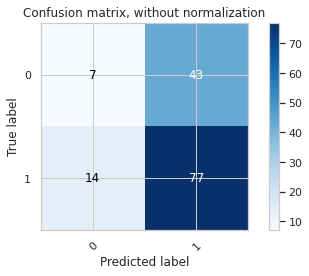

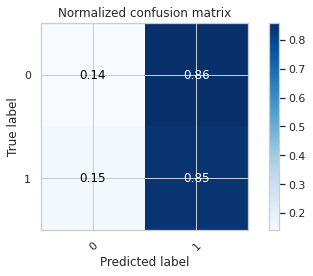

In [43]:
# Test model using the parameters from gridsearchCV
select_model(test_4, RandomForestClassifier(random_state=10, 
          max_depth = 5, 
          max_features= 'sqrt', 
          n_estimators= 50))
# Rename dataframe
svc = dataframe
# Accuracy is the number of correct predictions (TP + TN) / (TP + FP + FN + TN)
# correctness
# Precision is the number of picking correctly vs. picking incorrectly (TP) / (TP + FP)
# Recall is the number in the class that we actually classified to be in that class (TP) / (TP + FN)
# F-1 is a combination of precision and recall